In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
import PIL
import webdataset as wds
import os
import os.path
import io
from ocrlib import extract_seg
from random import randrange
import scipy.ndimage as ndi
import json

# Convert Raw UW3 Data to Usable JSON

In [3]:
def getboxes(text, target):
    if isinstance(text, bytes): text = text.decode("utf-8")
    lines = [l.strip() for l in text.split("\n")]
    result = []
    for l in lines:
        if (len(l)==5 and "=" not in l) or l == "":
            doc = None
            zone = None
            continue
        #print(l)
        k, v = re.split(" *= *", l, maxsplit=1)
        if k == "ZONE_ID":
            zone = v
        elif k== "DOCUMENT_ID":
            doc = v
        elif k == target:
            box = [int(x) for x in v.split()]
            result.append(dict(box=box, zone=zone, doc=doc))
        else:
            raise ValueError(f"{k}: {v} unknown")
    return result

In [4]:
orig = next(iter(wds.Dataset("uw3/uw3-original.tar").decode()))
orig.keys()

dict_keys(['__key__', '1cond.txt', '1ground.txt', '1pageattr.txt', '1pageboxs.txt', '1zoneattr.txt', '1zoneboxs.txt', 'dafs', 'dafs.txt', 'image.tif', 'labzones.txt', 'linebox.txt', 'wordbox.txt', 'zonebox.txt'])

In [5]:
def parse_zone_attr(attr):
    result = []
    r = None
    for line in attr.split("\n"):
        line = line.strip()
        if line == "":
            continue
        if line == "ZZZZZ":
            if r is not None:
                result.append(r)
            r = dict()
            continue
        F = [x.strip() for x in line.split("=", 1)]
        r[F[0]] = F[1]
    result.append(r)
    return result

def parse_zone_boxes(text):
    result = []
    r = None
    for line in text.split("\n"):
        line = line.strip()
        if line == "":
            continue
        if line == "BBBBB":
            if r is not None:
                result.append(r)
            r = dict()
            continue
        F = [x.strip() for x in line.split("=", 1)]
        r[F[0]] = F[1]
    result.append(r)
    return result


def parse_zones(orig):
    boxes = parse_zone_boxes(orig["zonebox.txt"])
    attr = parse_zone_attr(orig["1zoneattr.txt"])
    attr = {a["ZONE_ID"]: a for a in attr}
    for b in boxes:
        a = attr[b["ZONE_ID"]]
        assert a["PAGE_ID"] == b["DOCUMENT_ID"]
        assert a["ZONE_ID"] == b["ZONE_ID"]
        x0, y0 = map(int, b["CORNER_ONE_RC"].split())
        x1, y1 = map(int, b["CORNER_TWO_RC"].split())
        b["box"] = [y0, y1, x0, x1]
        b.update(a)
    return boxes

parse_zones(orig)

[{'DOCUMENT_ID': 'A001',
  'ZONE_ID': '000',
  'CORNER_ONE_RC': '799 195',
  'CORNER_TWO_RC': '1600 231',
  'box': [195, 231, 799, 1600],
  'PAGE_ID': 'A001',
  'ZONE_CONTENT': 'text',
  'ZONE_TYPE': 'page-header',
  'TEXT_ALIGNMENT': 'justified',
  'CHARACTER_ORIENTATION': 'up-right',
  'DOMINANT_FONT_TYPE': 'serif',
  'DOMINANT_FONT_SPACING': 'proportional',
  'DOMINANT_FONT_SIZE': '9-12',
  'DOMINANT_FONT_STYLE': 'plain',
  'TEXT_READING_DIRECTION': 'left-right',
  'LANGUAGE': 'English',
  'SCRIPT': 'Roman',
  'COLUMN_NUMBER': 'header-area',
  'NEXT_SEMANTICAL_ZONE': 'nil'},
 {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '001',
  'CORNER_ONE_RC': '1821 168',
  'CORNER_TWO_RC': '2221 302',
  'box': [168, 302, 1821, 2221],
  'PAGE_ID': 'A001',
  'ZONE_CONTENT': 'text',
  'ZONE_TYPE': 'page-header',
  'TEXT_ALIGNMENT': 'justified',
  'CHARACTER_ORIENTATION': 'up-right',
  'DOMINANT_FONT_TYPE': 'serif',
  'DOMINANT_FONT_SPACING': 'proportional',
  'DOMINANT_FONT_SIZE': '13-18',
  'DOMINANT_FONT_

In [6]:
print(orig["zonebox.txt"])

BBBBB
DOCUMENT_ID   = A001
ZONE_ID       = 000
CORNER_ONE_RC = 799 195
CORNER_TWO_RC = 1600 231
BBBBB
DOCUMENT_ID   = A001
ZONE_ID       = 001
CORNER_ONE_RC = 1821 168
CORNER_TWO_RC = 2221 302
BBBBB
DOCUMENT_ID   = A001
ZONE_ID       = 002
CORNER_ONE_RC = 1825 320
CORNER_TWO_RC = 2221 355
BBBBB
DOCUMENT_ID   = A001
ZONE_ID       = 003
CORNER_ONE_RC = 797 795
CORNER_TWO_RC = 1844 913
BBBBB
DOCUMENT_ID   = A001
ZONE_ID       = 004
CORNER_ONE_RC = 792 976
CORNER_TWO_RC = 1074 1014
BBBBB
DOCUMENT_ID   = A001
ZONE_ID       = 005
CORNER_ONE_RC = 859 1119
CORNER_TWO_RC = 2241 1655
BBBBB
DOCUMENT_ID   = A001
ZONE_ID       = 006
CORNER_ONE_RC = 860 1661
CORNER_TWO_RC = 2240 1901
BBBBB
DOCUMENT_ID   = A001
ZONE_ID       = 007
CORNER_ONE_RC = 801 2013
CORNER_TWO_RC = 1050 2043
BBBBB
DOCUMENT_ID   = A001
ZONE_ID       = 008
CORNER_ONE_RC = 799 2105
CORNER_TWO_RC = 2241 2294
BBBBB
DOCUMENT_ID   = A001
ZONE_ID       = 009
CORNER_ONE_RC = 799 2303
CORNER_TWO_RC = 2241 2591



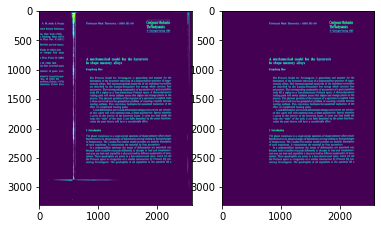

In [7]:
def pagebox(sample):
    locations = sample["zonebox.txt"]
    locations = locations if isinstance(locations, str) else locations.decode("utf-8")
    locations = locations.split("\n")
    locations = [x for x in locations if "_RC" in x]
    locations = [re.split(" *= *", x)[1] for x in locations]
    locations = array([[int(s) for s in x.split()] for x in locations])
    x0, y0 = amin(locations, axis=0)
    x1, y1 = amax(locations, axis=0)
    return x0, y0, x1, y1

def getimage(sample):
    image = PIL.Image.open(io.BytesIO(sample["image.tif"]))
    image = array(image, dtype="uint8")
    if amax(image) == 1:
        image *= 255
    image = amax(image) - image
    return image

def maskedimage(sample):
    x0, y0, x1, y1 = pagebox(sample)
    image = getimage(sample)
    mask = zeros(image.shape, dtype=image.dtype)
    mask[y0:y1, x0:x1] = 1
    return mask * image

subplot(121); imshow(getimage(orig))
subplot(122); imshow(maskedimage(orig))

In [6]:
if not os.path.exists("uw3/uw3-boxes.tar"):
    sink = wds.TarWriter("uw3/uw3-boxes.tar")
    for i, sample in enumerate(wds.Dataset("uw3/uw3-original.tar")):
        if i%100==0: print(i, sample["__key__"])
        image = maskedimage(sample)
        result = {
            "__key__": sample["__key__"],
            "page.png": image,
            "words.json": getboxes(sample["wordbox.txt"], "WORD_BOX"),
            "lines.json": getboxes(sample["linebox.txt"], "TEXT_LINE_BOX")
        }
        sink.write(result)
    sink.close()

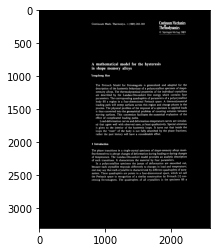

In [7]:
imshow(next(iter(wds.Dataset("uw3/uw3-boxes.tar").decode()))["page.png"])

# Create Segmentation Ground Truth Images

In [8]:
sink = wds.TarWriter("uw3/uw3-wordseg-markers.tar")
for i, sample in enumerate(wds.Dataset("uw3/uw3-boxes.tar").decode()):
    if i%100==0: print(i, sample["__key__"])
    image = sample["page.png"]
    #print(image.shape, amin(image), amax(image))
    bboxes = [s["box"] for s in sample["words.json"]]
    wordseg = extract_seg.marker_segmentation_target_for_bboxes(image, bboxes, inside=3)
    sink.write({
        "__key__": sample["__key__"],
        "image.png": image,
        "wordseg.png": wordseg,
    })
sink.close()

0 A001
100 A063
200 D038
300 E009
400 E048
500 H048
600 IG0F
700 K00F
800 N04L
900 S02N
1000 W020
1100 W0C3
1200 W0L3
1300 W114
1400 W1B1
1500 W1K2


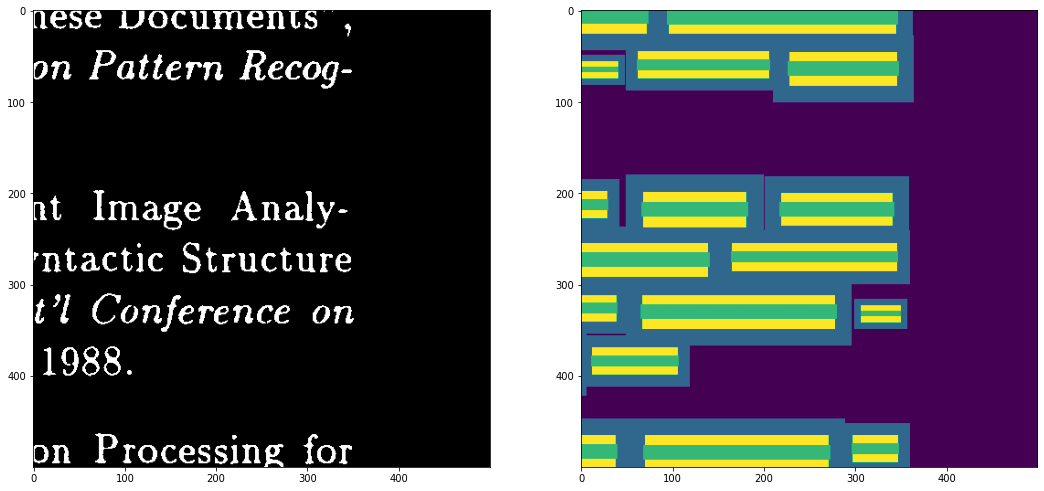

In [9]:
figsize(18, 9)
subplot(121); imshow(image[1000:1500,1000:1500])
subplot(122); imshow(wordseg[1000:1500,1000:1500])

In [25]:
sink = wds.TarWriter("uw3/uw3-wordseg-markers-masked.tar")
dilate = 20
for i, sample in enumerate(wds.Dataset("uw3/uw3-boxes.tar").decode()):
    if i%100==0: print(i, sample["__key__"])
    image = sample["page.png"]
    #print(image.shape, amin(image), amax(image))
    bboxes = [s["box"] for s in sample["words.json"]]
    wordseg = extract_seg.marker_segmentation_target_for_bboxes(image, bboxes, inside=3)
    mask = (wordseg > 0).astype(np.uint8)
    mask = ndi.maximum_filter(mask, dilate)
    image = image * mask[:, :, newaxis]
    sink.write({
        "__key__": sample["__key__"],
        "image.png": image,
        "mask.png": mask*255,
        "wordseg.png": wordseg,
    })
sink.close()

0 A001
100 A063
200 D038
300 E009
400 E048
500 H048
600 IG0F
700 K00F
800 N04L
900 S02N
1000 W020
1100 W0C3
1200 W0L3
1300 W114
1400 W1B1
1500 W1K2


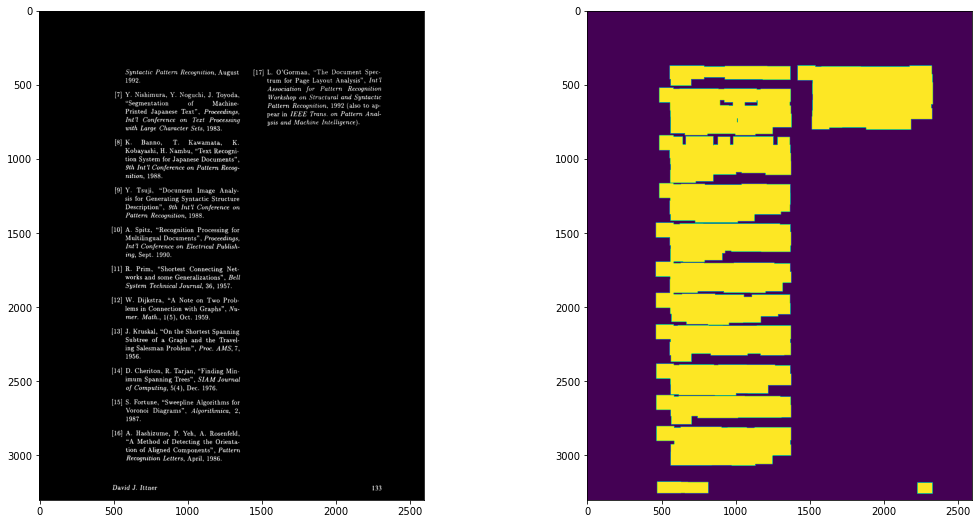

In [26]:
subplot(121); imshow(image)
subplot(122); imshow(mask)

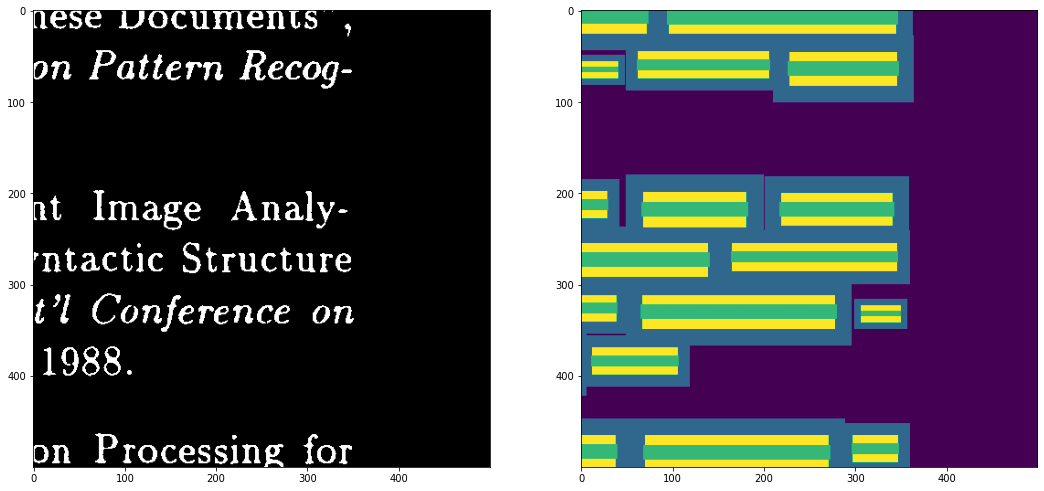

In [27]:
figsize(18, 9)
subplot(121); imshow(image[1000:1500,1000:1500])
subplot(122); imshow(wordseg[1000:1500,1000:1500])

In [10]:
sink = wds.TarWriter("uw3/uw3-lineseg-markers.tar")
for i, sample in enumerate(wds.Dataset("uw3/uw3-boxes.tar").decode()):
    if i%100==0: print(i, sample["__key__"])
    image = sample["page.png"]
    #print(image.shape, amin(image), amax(image))
    bboxes = [s["box"] for s in sample["lines.json"]]
    lineseg = extract_seg.marker_segmentation_target_for_bboxes(image, bboxes, inside=3)
    sink.write({
        "__key__": sample["__key__"],
        "image.png": image,
        "lineseg.png": lineseg,
    })
    #break
sink.close()

0 A001
100 A063
200 D038
300 E009
400 E048
500 H048
600 IG0F
700 K00F
800 N04L
900 S02N
1000 W020
1100 W0C3
1200 W0L3
1300 W114
1400 W1B1
1500 W1K2


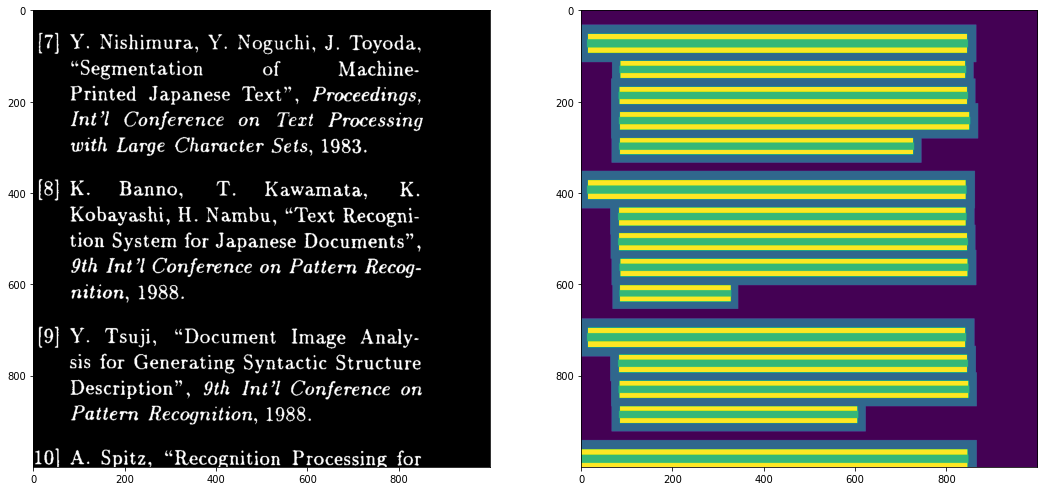

In [11]:
figsize(18, 9)
subplot(121); imshow(image[500:1500,500:1500])
subplot(122); imshow(lineseg[500:1500,500:1500])

sink = wds.TarWriter("uw3/uw3-wordseg-markers.tar")
for i, sample in enumerate(wds.Dataset("uw3/uw3-boxes.tar").decode()):
    if i%100==0: print(i, sample["__key__"])
    image = sample["page.png"]
    #print(image.shape, amin(image), amax(image))
    bboxes = [s["box"] for s in sample["words.json"]]
    lineseg = extract_seg.marker_segmentation_target_for_bboxes(image, bboxes)
    sink.write({
        "__key__": sample["__key__"],
        "image.png": image,
        "wordseg.png": lineseg,
    })
    #break
sink.close()

figsize(18, 9)
subplot(121); imshow(image[500:1500,500:1500])
subplot(122); imshow(lineseg[500:1500,500:1500])

# Extract Patches

In [29]:
ph, pw = 1024, 1024
npatches = 100

In [13]:
sink = wds.TarWriter("uw3/uw3-lineseg-markers-patches.tar")
for i, (key, image, seg) in enumerate(wds.Dataset("uw3/uw3-lineseg-markers.tar")
                                      .decode("l8")
                                      .to_tuple("__key__ image.png lineseg.png")):
    if i%100==0:
        print(i, key)
    assert image.ndim==2
    assert image.shape[:2] == seg.shape, (image.shape, seg.shape)
    h, w = image.shape
    count = 0
    for j in range(10000):
        if count >= npatches: break
        y, x = randrange(0, h-ph), randrange(0, w-pw)
        spatch = seg[y:y+ph, x:x+pw]
        badpatch = (spatch==2).sum() < 10 or (spatch==1).sum() < 10
        if badpatch and uniform() > 0.03: continue
        ipatch = image[y:y+ph, x:x+pw]
        result = {
            "__key__":  f"{key}-{count}",
            "ipatch.png": ipatch,
            "spatch.png": spatch
        }
        sink.write(result)
        count += 1
sink.close()

0 A001
100 A063
200 D038
300 E009
400 E048
500 H048
600 IG0F
700 K00F
800 N04L
900 S02N
1000 W020
1100 W0C3
1200 W0L3
1300 W114
1400 W1B1
1500 W1K2


In [14]:
sink = wds.TarWriter("uw3/uw3-wordseg-markers-patches.tar")
for i, (key, image, seg) in enumerate(wds.Dataset("uw3/uw3-wordseg-markers.tar")
                                      .decode("l8")
                                      .to_tuple("__key__ image.png wordseg.png")):
    if i%100==0:
        print(i, key)
    assert image.ndim==2
    assert image.shape[:2] == seg.shape, (image.shape, seg.shape)
    h, w = image.shape
    count = 0
    for j in range(10000):
        if count >= npatches: break
        y, x = randrange(0, h-ph), randrange(0, w-pw)
        spatch = seg[y:y+ph, x:x+pw]
        badpatch = (spatch==2).sum() < 10 or (spatch==1).sum() < 10
        if badpatch and uniform() > 0.03: continue
        ipatch = image[y:y+ph, x:x+pw]
        result = {
            "__key__":  f"{key}-{count}",
            "ipatch.png": ipatch,
            "spatch.png": spatch
        }
        sink.write(result)
        count += 1
sink.close()

0 A001
100 A063
200 D038
300 E009
400 E048
500 H048
600 IG0F
700 K00F
800 N04L
900 S02N
1000 W020
1100 W0C3
1200 W0L3
1300 W114
1400 W1B1
1500 W1K2


In [30]:
sink = wds.TarWriter("uw3/uw3-wordseg-markers-masked-patches.tar")
for i, (key, image, seg) in enumerate(wds.Dataset("uw3/uw3-wordseg-markers-masked.tar")
                                      .decode("l8")
                                      .to_tuple("__key__ image.png wordseg.png")):
    if i%100==0:
        print(i, key)
    assert image.ndim==2
    assert image.shape[:2] == seg.shape, (image.shape, seg.shape)
    h, w = image.shape
    count = 0
    for j in range(10000):
        if count >= npatches: break
        y, x = randrange(0, h-ph), randrange(0, w-pw)
        spatch = seg[y:y+ph, x:x+pw]
        badpatch = (spatch==2).sum() < 10 or (spatch==1).sum() < 10
        if badpatch and uniform() > 0.03: continue
        ipatch = image[y:y+ph, x:x+pw]
        result = {
            "__key__":  f"{key}-{count}",
            "ipatch.png": ipatch,
            "spatch.png": spatch
        }
        sink.write(result)
        count += 1
sink.close()

0 A001
100 A063
200 D038
300 E009
400 E048
500 H048
600 IG0F
700 K00F
800 N04L
900 S02N
1000 W020
1100 W0C3
1200 W0L3
1300 W114
1400 W1B1
1500 W1K2


In [15]:
!rm -f uw3/uw3-wordseg-markers-patches-*.tar
!tarp cat -s 20000 uw3/uw3-wordseg-markers-patches.tar -o - | tarp split - -s 5e8 -o uw3/uw3-wordseg-markers-patches-%06d.tar

[info] # shuffle 20000
[progress] # writing -
[progress] # source uw3/uw3-wordseg-markers-patches.tar
[progress] # source -
[progress] # shard uw3/uw3-wordseg-markers-patches-000000.tar
[progress] # shard uw3/uw3-wordseg-markers-patches-000001.tar
[progress] # shard uw3/uw3-wordseg-markers-patches-000002.tar
[progress] # shard uw3/uw3-wordseg-markers-patches-000003.tar
[progress] # shard uw3/uw3-wordseg-markers-patches-000004.tar
[progress] # shard uw3/uw3-wordseg-markers-patches-000005.tar
[progress] # shard uw3/uw3-wordseg-markers-patches-000006.tar
[progress] # shard uw3/uw3-wordseg-markers-patches-000007.tar
[progress] # shard uw3/uw3-wordseg-markers-patches-000008.tar
[progress] # shard uw3/uw3-wordseg-markers-patches-000009.tar
[progress] # shard uw3/uw3-wordseg-markers-patches-000010.tar
[progress] # shard uw3/uw3-wordseg-markers-patches-000011.tar


In [16]:
!rm -f uw3/uw3-lineseg-markers-patches-*.tar
!tarp cat -s 20000 uw3/uw3-lineseg-markers-patches.tar -o - | tarp split - -s 5e8 -o uw3/uw3-lineseg-markers-patches-%06d.tar

[info] # shuffle 20000
[progress] # writing -
[progress] # source uw3/uw3-lineseg-markers-patches.tar
[progress] # source -
[progress] # shard uw3/uw3-lineseg-markers-patches-000000.tar
[progress] # shard uw3/uw3-lineseg-markers-patches-000001.tar
[progress] # shard uw3/uw3-lineseg-markers-patches-000002.tar
[progress] # shard uw3/uw3-lineseg-markers-patches-000003.tar
[progress] # shard uw3/uw3-lineseg-markers-patches-000004.tar
[progress] # shard uw3/uw3-lineseg-markers-patches-000005.tar
[progress] # shard uw3/uw3-lineseg-markers-patches-000006.tar
[progress] # shard uw3/uw3-lineseg-markers-patches-000007.tar
[progress] # shard uw3/uw3-lineseg-markers-patches-000008.tar
[progress] # shard uw3/uw3-lineseg-markers-patches-000009.tar
[progress] # shard uw3/uw3-lineseg-markers-patches-000010.tar


In [31]:
!rm -f uw3/uw3-wordseg-markers-patches-*.tar
!tarp cat -s 20000 uw3/uw3-wordseg-markers-masked-patches.tar -o - | tarp split - -s 5e8 -o uw3/uw3-wordseg-markers-masked-patches-%06d.tar

[info] # shuffle 20000
[progress] # writing -
[progress] # source uw3/uw3-wordseg-markers-masked-patches.tar
[progress] # source -
[progress] # shard uw3/uw3-wordseg-markers-masked-patches-000000.tar
[progress] # shard uw3/uw3-wordseg-markers-masked-patches-000001.tar
[progress] # shard uw3/uw3-wordseg-markers-masked-patches-000002.tar
[progress] # shard uw3/uw3-wordseg-markers-masked-patches-000003.tar
[progress] # shard uw3/uw3-wordseg-markers-masked-patches-000004.tar
[progress] # shard uw3/uw3-wordseg-markers-masked-patches-000005.tar
[progress] # shard uw3/uw3-wordseg-markers-masked-patches-000006.tar
[progress] # shard uw3/uw3-wordseg-markers-masked-patches-000007.tar
[progress] # shard uw3/uw3-wordseg-markers-masked-patches-000008.tar
[progress] # shard uw3/uw3-wordseg-markers-masked-patches-000009.tar
[progress] # shard uw3/uw3-wordseg-markers-masked-patches-000010.tar


In [6]:
#sink = wds.TarWriter("uw3/uw3-temp.tar")
for i, sample in enumerate(wds.Dataset("uw3/uw3-boxes.tar").decode()):
    break

In [7]:
sample.keys()

dict_keys(['__key__', 'lines.json', 'page.png', 'words.json'])

In [8]:
sample["lines.json"]

[{'box': [799, 195, 1600, 231], 'zone': '000', 'doc': 'A001'},
 {'box': [1821, 168, 2221, 219], 'zone': '001', 'doc': 'A001'},
 {'box': [1892, 223, 1930, 253], 'zone': '001', 'doc': 'A001'},
 {'box': [1821, 241, 2130, 302], 'zone': '001', 'doc': 'A001'},
 {'box': [1825, 320, 2221, 355], 'zone': '002', 'doc': 'A001'},
 {'box': [797, 795, 1844, 850], 'zone': '003', 'doc': 'A001'},
 {'box': [798, 859, 1405, 913], 'zone': '003', 'doc': 'A001'},
 {'box': [792, 976, 1074, 1014], 'zone': '004', 'doc': 'A001'},
 {'box': [860, 1119, 2240, 1160], 'zone': '005', 'doc': 'A001'},
 {'box': [861, 1168, 2239, 1210], 'zone': '005', 'doc': 'A001'},
 {'box': [861, 1217, 2240, 1259], 'zone': '005', 'doc': 'A001'},
 {'box': [861, 1266, 2240, 1309], 'zone': '005', 'doc': 'A001'},
 {'box': [860, 1315, 2240, 1358], 'zone': '005', 'doc': 'A001'},
 {'box': [861, 1364, 2240, 1407], 'zone': '005', 'doc': 'A001'},
 {'box': [861, 1415, 2240, 1457], 'zone': '005', 'doc': 'A001'},
 {'box': [859, 1464, 2240, 1507], 'z

In [9]:
for i, sample in enumerate(wds.Dataset("uw3/uw3-original.tar").decode()):
    break
sample.keys()

dict_keys(['__key__', '1cond.txt', '1ground.txt', '1pageattr.txt', '1pageboxs.txt', '1zoneattr.txt', '1zoneboxs.txt', 'dafs', 'dafs.txt', 'image.tif', 'labzones.txt', 'linebox.txt', 'wordbox.txt', 'zonebox.txt'])

In [24]:
def parse_lboxes(sample):
    r = {}
    result = {}
    for l in sample["linebox.txt"].strip().split("\n")[1:] + ["LLLLL"]:
        #print("#", l)
        if l=="LLLLL":
            assert r["ZONE_ID"] not in result
            result[r["ZONE_ID"]] = r
            r = {}
            continue
        k, v = [s.strip() for s in l.split("=", 1)]
        if k == "TEXT_LINE_BOX":
            r.setdefault("lboxes", []).append(tuple(int(x) for x in v.split()))
        else:
            r[k] = v
    return result
parse_lboxes(sample)

{'000': {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '000',
  'lboxes': [(799, 195, 1600, 231)]},
 '001': {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '001',
  'lboxes': [(1821, 168, 2221, 219),
   (1892, 223, 1930, 253),
   (1821, 241, 2130, 302)]},
 '002': {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '002',
  'lboxes': [(1825, 320, 2221, 355)]},
 '003': {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '003',
  'lboxes': [(797, 795, 1844, 850), (798, 859, 1405, 913)]},
 '004': {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '004',
  'lboxes': [(792, 976, 1074, 1014)]},
 '005': {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '005',
  'lboxes': [(860, 1119, 2240, 1160),
   (861, 1168, 2239, 1210),
   (861, 1217, 2240, 1259),
   (861, 1266, 2240, 1309),
   (860, 1315, 2240, 1358),
   (861, 1364, 2240, 1407),
   (861, 1415, 2240, 1457),
   (859, 1464, 2240, 1507),
   (861, 1515, 2240, 1556),
   (862, 1563, 2241, 1605),
   (860, 1617, 1508, 1655)]},
 '006': {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '006',
  'lboxes': [(922, 1661, 2239, 1703),
   (860,

In [26]:
def parse_gt(sample):
    r = {}
    result = {}
    lines = sample["1ground.txt"].strip().split("\n") + ["GGGGG"]
    while len(lines) > 0:
        assert lines[0] == "GGGGG"
        if len(lines) == 1:
            break
        doc = lines[1]
        zone = lines[2]
        gt = []
        del lines[:3]
        while lines[0] != "GGGGG":
            gt.append(lines[0])
            del lines[0]
        result[zone] = dict(DOCUMENT_ID=doc, ZONE_ID=zone, gt=gt)
    return result
parse_gt(sample)

{'000': {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '000',
  'gt': ['Continuum Mech. Thermodyn. 1 (1989) 283-303']},
 '001': {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '001',
  'gt': ['Continuum Mechanics', 'and', 'Thermodynamics']},
 '002': {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '002',
  'gt': ['\\copyright Springer-Verlag 1989']},
 '003': {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '003',
  'gt': ['A mathematical model for the hysteresis', 'in shape memory alloys']},
 '004': {'DOCUMENT_ID': 'A001', 'ZONE_ID': '004', 'gt': ['Yongzhong Huo']},
 '005': {'DOCUMENT_ID': 'A001',
  'ZONE_ID': '005',
  'gt': ['The Preisach Model for ferromagnets is generalized and adapted for the',
   'description of the hysteretic behaviour of a polycrystalline specimen of shape-',
   'memory alloys. The thermodynamical properties of the individual crystallites',
   'are described by the Landau-Devonshire free energy which contains four',
   'parameters. The corresponding quadruplets of parameters of a polycrystalline',
   'body

In [36]:
gt = parse_gt(sample)
bb = parse_lboxes(sample)
result = []
for zone in gt.keys():
    assert zone in bb
    assert gt[zone]["DOCUMENT_ID"] == bb[zone]["DOCUMENT_ID"]
    assert gt[zone]["ZONE_ID"] == bb[zone]["ZONE_ID"]
    textlines = gt[zone]["gt"]
    boxes = bb[zone]["lboxes"]
    assert len(textlines) == len(boxes)
    for txt, bbox in zip(textlines, boxes):
        r = dict(
            doc=gt[zone]["DOCUMENT_ID"],
            zone=gt[zone]["ZONE_ID"],
            bbox=bbox,
            txt=txt
        )
        result.append(r)

In [43]:
image = np.array(PIL.Image.open(io.BytesIO(sample["image.tif"])))

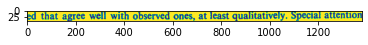

In [51]:
x0, y0, x1, y1 = result[20]["bbox"]
imshow(image[y0:y1, x0:x1])